In [1]:
import torch
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import AutoTokenizer,AutoModelForSequenceClassification, DataCollatorWithPadding
from transformers import Trainer, TrainingArguments, AutoConfig
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score ,accuracy_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import os 
import time
import re
from string import ascii_lowercase
import seaborn as sns
from imblearn.over_sampling import SMOTE
import seaborn as sbn
os.environ["WANDB_DISABLED"] = "true"
import warnings

# Bỏ qua tất cả các cảnh báo
warnings.filterwarnings("ignore")

SEED = 15
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def clean(data):
    data = data.lower() 
    with open('/kaggle/input/datacomments/teencode4.txt','r') as file:
      file = file.read()
      lines = file.split('\n')
      for line in lines:
        elements = line.split('\t')
        data = re.sub(r'\b{}+\b'.format(elements[0]), elements[1], data)
    alphabet = 'abcdefghijlmnopqrstuvwxyz'
    for c in alphabet:
      data = re.sub(r'{}+'.format(c), c, data)

    data = re.sub(r'\s+', ' ', data)
    return data

In [3]:
# call the function
df_train = pd.read_excel('/kaggle/input/uit-vsmec/UIT-VSMEC/train_nor_811.xlsx')
df_test =  pd.read_excel('/kaggle/input/uit-vsmec/UIT-VSMEC/test_nor_811.xlsx')
df_valid = pd.read_excel('/kaggle/input/uit-vsmec/UIT-VSMEC/valid_nor_811.xlsx')

df_train['Sentence'] = df_train['Sentence'].apply(clean)
df_test['Sentence'] = df_test['Sentence'].apply(clean)
df_valid['Sentence'] = df_valid['Sentence'].apply(clean)



test_texts = list(df_test['Sentence'])
train_texts = list(df_train['Sentence'])
valid_texts = list(df_valid['Sentence'])

y= LabelEncoder()

train_labels = y.fit_transform(df_train['Emotion'])
valid_labels = y.fit_transform(df_valid['Emotion'])
test_labels = y.fit_transform(df_test['Emotion'])

target_names = list(df_train.Emotion.unique())

In [4]:
# check text classification models here: https://huggingface.co/models?filter=text-classification
 
model_name = "xlm-roberta-base" #66 65 66 256 66 65 66 512
# max sequence length for each document/sentence sample
max_length = 256
# load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)

In [5]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length`
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=max_length)

In [6]:
# https://huggingface.co/transformers/v3.4.0/custom_datasets.html
class NewsGroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset

train_dataset = NewsGroupsDataset(train_encodings, train_labels)
valid_dataset = NewsGroupsDataset(valid_encodings, valid_labels)
test_dataset = NewsGroupsDataset(test_encodings, test_labels)

In [7]:
label2id = {"Anger": 0, "Disgust": 1, "Enjoyment": 2, "Fear": 3, "Other": 4, "Sadness": 5, "Surprise": 6}
id2label = {0: "Anger", 1: "Disgust", 2: "Enjoyment", 3: "Fear", 4: "Other", 5: "Sadness", 6: "Surprise"}

model = AutoModelForSequenceClassification.from_pretrained(model_name,label2id=label2id,
                        id2label=id2label, num_labels=7)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

In [8]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # calculate accuracy using sklearn's function
    acc = accuracy_score(labels, preds)
    return {
      'accuracy': acc,
    }


training_args = TrainingArguments(
    output_dir='my_model',          # output directory
    evaluation_strategy="epoch",
    save_strategy='epoch',
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    greater_is_better=True,
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=400,                # number of warmup steps for learning rate scheduler
    weight_decay=0.1,               # strength of weight decay
    learning_rate=5e-5,
    gradient_accumulation_steps=1,
    lr_scheduler_type="cosine",
    logging_steps = round(len(train_dataset) / 16),
    save_total_limit = 2

)
data_collator_ = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model= model,
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,     # the callback that computes metrics of interestm,
    data_collator = data_collator_,
    # optimizers=(optimizer, lr_scheduler)
)
# train the model


time_start = time.time()

trainer.train()



# evaluate the current model after training

time_end = time.time()  
total_time = time_end - time_start
trainer.evaluate()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.691400,1.386750,0.473761
2,1.285400,1.207939,0.558309
3,0.997200,1.130282,0.591837
4,0.716100,1.218511,0.586006
5,0.498500,1.263742,0.590379


{'eval_loss': 1.1302824020385742,
 'eval_accuracy': 0.5918367346938775,
 'eval_runtime': 2.1858,
 'eval_samples_per_second': 313.839,
 'eval_steps_per_second': 19.672,
 'epoch': 5.0}

In [9]:
from sklearn.metrics import classification_report
import numpy as np
pred = trainer.predict(test_dataset)

y_pred = np.argmax(pred.predictions, axis=1)

print(classification_report(test_labels,y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.382     0.325     0.351        40
           1      0.618     0.636     0.627       132
           2      0.720     0.798     0.757       193
           3      0.574     0.587     0.581        46
           4      0.584     0.620     0.602       129
           5      0.816     0.690     0.748       116
           6      0.519     0.378     0.438        37

    accuracy                          0.652       693
   macro avg      0.602     0.576     0.586       693
weighted avg      0.651     0.652     0.649       693



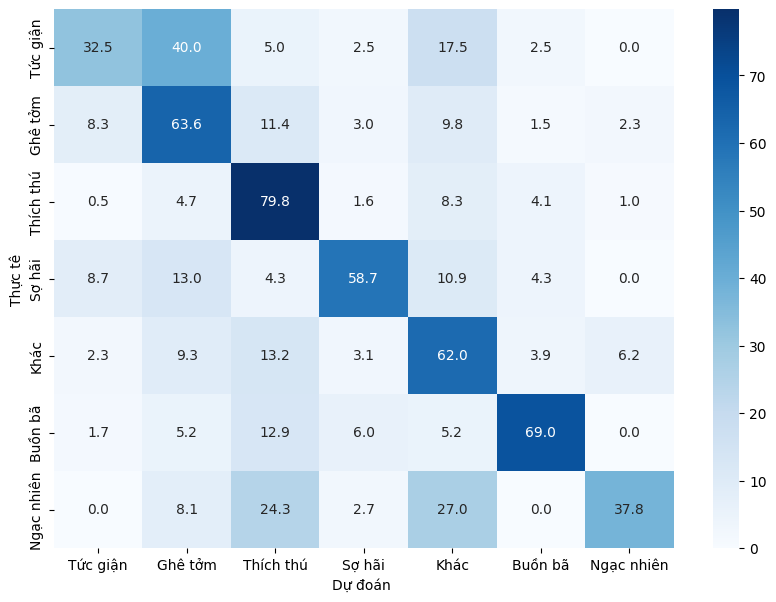

In [10]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import seaborn as sns
confuse = confusion_matrix(test_labels, y_pred)

fig = plt.figure(figsize=(10, 7))
id2label = {0: "Anger", 1: "Disgust", 2: "Enjoyment", 3: "Fear", 4: "Other", 5: "Sadness", 6: "Surprise"}



ax = sns.heatmap( np.round(np.divide(confuse, np.sum(confuse, axis=1).reshape(-1, 1)) * 100, 1), fmt="", annot=True, cmap='Blues')
# ax.set_title('fgh')
ax.set_xlabel('Dự đoán ')
ax.set_ylabel('Thực tê');

ax.xaxis.set_ticklabels(["Tức giận",  "Ghê tởm", "Thích thú", "Sợ hãi", "Khác", "Buồn bã", "Ngạc nhiên"])
ax.yaxis.set_ticklabels(["Tức giận",  "Ghê tởm", "Thích thú", "Sợ hãi", "Khác", "Buồn bã", "Ngạc nhiên"])

plt.show() #133